In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import datetime

from glob import glob
from natsort import natsorted
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm.auto import tqdm
from unet import *
from imaris_ims_file_reader.ims import ims
from aicspylibczi import CziFile
torch.backends.cudnn.benchmark = True

In [62]:
##Bioformats stuff
#!pip install aicspylibczi
#!pip install aicsimageio
### Just for testing###
##!pip install aicsimageio bioformats_jar  # brings down bioformats deps
###

#!pip install imaris-ims-file-reader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 9.0 MB/s eta 0:00:006.0 MB/s eta 0:00:01
  Using cached psutil-5.9.1-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (284 kB)


In [63]:
# ##Bioformats stuff
# from aicspylibczi import CziFile
# from aicsimageio import AICSImage

# from pathlib import Path
# from imaris_ims_file_reader.ims import ims
# print(os.path.exists('/home/nelsonm/Downloads/2021-08-22_AZBA_segmentation.ims'))
# img = AICSImage('/home/nelsonm/Downloads/2021-08-22_AZBA_segmentation.ims')
# img.xarray_dask_data 

True


UnsupportedFileFormatError: AICSImage does not support the image: '/home/nelsonm/Downloads/2021-08-22_AZBA_segmentation.ims'. File extension suggests format: 'ims'. Install extra format dependency with: `pip install bioformats_jar`. See all known format extensions and their extra install name with `aicsimageio.formats.FORMAT_IMPLEMENTATIONS`. If the extra dependency is already installed this error may have raised because the file is corrupt or similar issue. For potentially more information and to help debug, try loading the file directly with the desired file format reader instead of with the AICSImage object.

In [64]:
ls /mnt/shared/potatoshapes/shannonsdata/raw_data/LightSheet_data/

Texas_red_coverslip1_cell1_surfaces.ims


In [65]:
pth = Path('/mnt/shared/potatoshapes/shannonsdata/raw_data/LightSheet_data/Texas_red_coverslip1_cell1_surfaces.ims')
a = ims(pth)


Opening readonly file: /mnt/shared/potatoshapes/shannonsdata/raw_data/LightSheet_data/Texas_red_coverslip1_cell1_surfaces.ims 



PermissionError: [Errno 13] Unable to open file (unable to open file: name = '/mnt/shared/potatoshapes/shannonsdata/raw_data/LightSheet_data/Texas_red_coverslip1_cell1_surfaces.ims', errno = 13, error message = 'Permission denied', flags = 40, o_flags = 0)

In [33]:
pth = Path('/mnt/shared/potatoshapes/shannonsdata/raw_data/3D_data/20220420_MSI-11_well 1_cell 1_untreated_Linear unmixing.czi')
czi = CziFile(pth)

# Get the shape of the data, the coordinate pairs are (start index, size)
#dimensions = czi.dims_shape()  #  [{'X': (0, 1900), 'Y': (0, 1300), 'Z': (0, 60), 'C': (0, 4), 'S': (0, 40), 'B': (0, 1)}]

czi.dims  #  BSCZYX

czi.size  #  (1, 40, 4, 60, 1300, 1900)

# Load the image slice I want from the file
img, shp = czi.read_image()

In [41]:
shp

[('B', 1), ('V', 1), ('T', 1), ('C', 6), ('Z', 33), ('Y', 1688), ('X', 1688)]

(-0.5, 1687.5, 1687.5, -0.5)

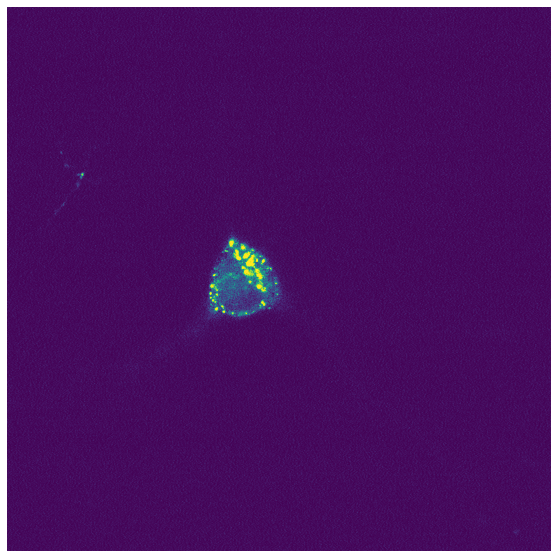

In [36]:
#need some kind of global min max
def norm_by(x, min_, max_):
    norms = np.percentile(x, [min_, max_])
    i2 = np.clip((x - norms[0])/(norms[1]-norms[0]), 0, 1)
    return i2

def recolor(im): # transform from rgb to cyan-magenta-yellow
    im_shape = np.array(im.shape)
    color_transform = np.array([[1, 1, 0], [0, 1, 1], [1, 0, 1]]).T
    im_reshape = im.reshape([np.prod(im_shape[0:2]), im_shape[2]]).T
    im_recolored = np.matmul(color_transform.T, im_reshape).T
    im_shape[2] = 3
    im = im_recolored.reshape(im_shape)
    return im

#normalize, combine into RGB and transform to CMY
c1 = (norm_by(img[0,0, 0, 3, 16, :, :], 50, 99.8)*255).astype(np.uint8)
#c2 = (norm_by(img[0,0, 0, 1, 0, :, :], 50, 99.8)*255).astype(np.uint8)
#c3 = (norm_by(img[0,0, 0, 2, 0, :, :], 0, 100)*255).astype(np.uint8)
#rgb = np.stack((c1), axis=2)
cmy = np.clip(recolor(rgb), 0, 255)

# plot using matplotlib¶
plt.figure(figsize=(10,10))
plt.imshow(c1)
plt.axis('off')

In [7]:
ls /mnt/shared/potatoshapes/shannonsdata/raw_data/3D_data

'20220420_MSI-11_Original file name information.csv'*
'20220420_MSI-11_well 1_cell 1_untreated_Linear unmixing.czi'*
'20220420_MSI-11_well 1_cell 2_untreated_Linear unmixing.czi'*
'20220427_MSI-12_Original file name information.csv'*
'20220428_uMSI-1_Original file name information.csv'*


In [ ]:

train_masks_list = natsorted(glob('/mnt/shared/potatoshapes/shannonsdata/raw_data/*cyto*'))

train_unmixed_lamp1_list = [i for i in natsorted(glob('/mnt/shared/potatoshapes/shannonsdata/raw_data/*cyto*.tif')) if 's.tif' not in i]

## TO DO adjust paths ##
test_masks_list = natsorted(glob('woodshole/test/*nuclei*'))
test_raw_list = [i for i in natsorted(glob('woodshole/test/*.tif')) if 's.tif' not in i]


In [ ]:
class RhoadsScholarDataset(Dataset):
    def __init__(self,
                 root_dir,
                 split='train'
                ):
        ########
        #FIX THIS
        ########
        self.mask_files = natsorted(glob(os.path.join(root_dir, split, f'*{mask}*')))
        self.raw_files = [i for i in natsorted(glob(os.path.join(root_dir, split, '*.tif'))) if 's.tif' not in i]
                
    def __len__(self):
        return len(self.raw_files)
        
    def __getitem__(self, idx):
        # get file names
        raw_file_path =  self.raw_files[idx]
        mask_file_path = self.mask_files[idx]
        
        # read in files
        
        ##For CZI
        raw = np.squeeze(np.squeeze(np.squeeze(CziFile(raw_file_path))))
        ##For IMS
        #raw = np.squeeze(np.squeeze(np.squeeze(ims(raw_file_path))))
        mask = imread(mask_file_path)

        # for now just do single channel training
        #raw = raw[0]

        return raw, mask


In [ ]:
train_dataset = RhoadsScholarDataset(root_dir='woodshole', split='train')